In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Check if CUDA is available and use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_paths = []
        self.labels = []
        
        class_names = os.listdir(image_dir)
        self.class_map = {class_name: idx for idx, class_name in enumerate(class_names)}
        
        for class_name in class_names:
            class_folder = os.path.join(image_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(self.class_map[class_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224, as CNN models typically expect this input size
        
        label = self.labels[idx]
        
        # Convert the image to tensor directly without transforms
        img = torch.tensor(img).float()
        img = img.permute(2, 0, 1)  # Change shape from HWC to CHW format
        
        return img, label

In [4]:
# Load datasets
train_dir = './New Dataset_new/Train'  # Path to your training data folder
test_dir = './New Dataset_new/Test'  # Path to your test data folder

In [5]:
train_dataset = PlantDiseaseDataset(train_dir)
test_dataset = PlantDiseaseDataset(test_dir)

Training class distribution: Counter({0: 2000, 1: 2000, 2: 2000, 3: 2000})
Test class distribution: Counter({0: 100, 1: 100, 2: 100, 3: 100})


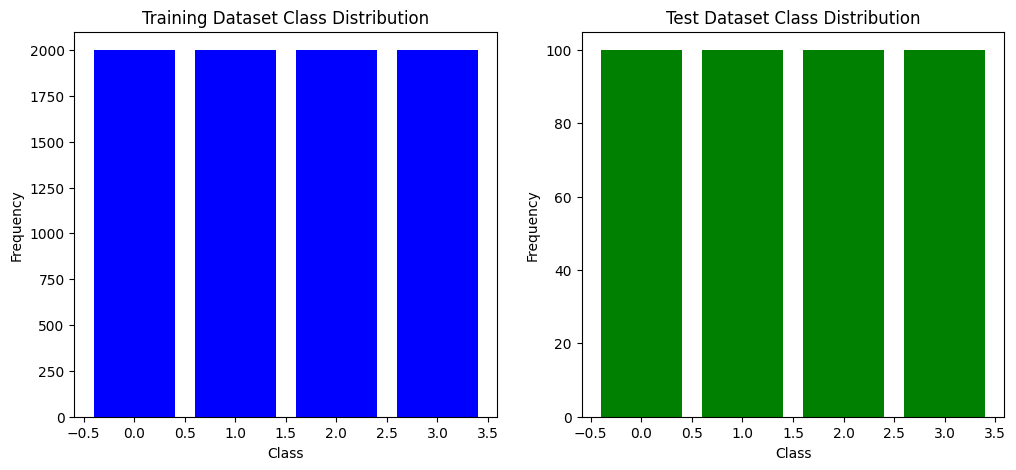

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Check class distribution in the training dataset
train_labels = [label for _, label in train_dataset]
train_class_counts = Counter(train_labels)
print("Training class distribution:", train_class_counts)

# Check class distribution in the test dataset
test_labels = [label for _, label in test_dataset]
test_class_counts = Counter(test_labels)
print("Test class distribution:", test_class_counts)

# Plotting the class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training dataset distribution
ax[0].bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
ax[0].set_title('Training Dataset Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Test dataset distribution
ax[1].bar(test_class_counts.keys(), test_class_counts.values(), color='green')
ax[1].set_title('Test Dataset Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

plt.show()

In [7]:
# Display class names with class numbers
class_names = train_dataset.class_map
for class_name, class_number in class_names.items():
    print(f"Class Name: {class_name}, Class Number: {class_number}")

Class Name: Bacterial Leaf Disease, Class Number: 0
Class Name: Dried Leaf, Class Number: 1
Class Name: Fungal Brown Spot Disease, Class Number: 2
Class Name: Healthy Leaf, Class Number: 3


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Define improved custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        
        # Define the layers of the custom CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.conv6 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(2048)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(2048 * 3 * 3, 4096)  # Adjusted input size
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = self.pool(torch.relu(self.bn6(self.conv6(x))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x


In [10]:
# Initialize the model, loss function, and optimizer
model = CustomCNN(num_classes=4)
model = model.to(device)

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
# Updated training loop to store loss and accuracy
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss = []
    train_accuracy = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_predictions
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    print("Training finished!")
    return train_loss, train_accuracy


In [13]:

# Train the model and get the loss and accuracy values
train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch [1/20], Loss: 0.4274, Accuracy: 80.89%
Epoch [2/20], Loss: 0.2951, Accuracy: 87.96%
Epoch [3/20], Loss: 0.2396, Accuracy: 90.66%
Epoch [4/20], Loss: 0.2005, Accuracy: 92.65%
Epoch [5/20], Loss: 0.1160, Accuracy: 95.90%
Epoch [6/20], Loss: 0.1003, Accuracy: 96.54%
Epoch [7/20], Loss: 0.0731, Accuracy: 97.65%
Epoch [8/20], Loss: 0.0575, Accuracy: 98.11%
Epoch [9/20], Loss: 0.0498, Accuracy: 98.45%
Epoch [10/20], Loss: 0.0507, Accuracy: 98.34%
Epoch [11/20], Loss: 0.0433, Accuracy: 98.59%
Epoch [12/20], Loss: 0.0461, Accuracy: 98.65%
Epoch [13/20], Loss: 0.0372, Accuracy: 98.65%
Epoch [14/20], Loss: 0.0496, Accuracy: 98.53%
Epoch [15/20], Loss: 0.0304, Accuracy: 99.03%
Epoch [16/20], Loss: 0.0319, Accuracy: 98.97%
Epoch [17/20], Loss: 0.0229, Accuracy: 99.21%
Epoch [18/20], Loss: 0.0191, Accuracy: 99.41%
Epoch [19/20], Loss: 0.0321, Accuracy: 99.03%
Epoch [20/20], Loss: 0.0196, Accuracy: 99.25%
Training finished!


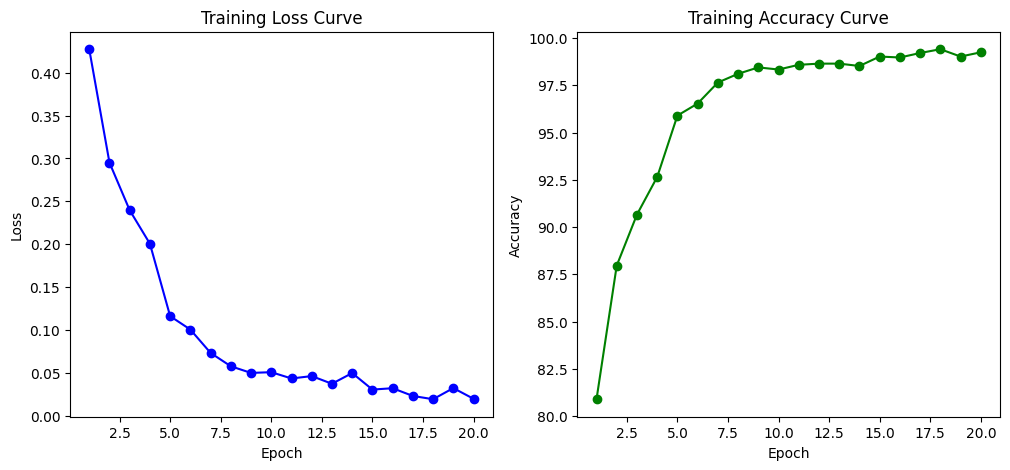

In [15]:


# Plotting the loss and accuracy curves
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve
ax[0].plot(range(1, 21), train_loss, marker='o', color='blue')
ax[0].set_title('Training Loss Curve')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

# Accuracy curve
ax[1].plot(range(1, 21), train_accuracy, marker='o', color='green')
ax[1].set_title('Training Accuracy Curve')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

plt.show()

In [16]:
# Evaluate model
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf']))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, ['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf'], rotation=45)
    plt.yticks(tick_marks, ['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf'])
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Classification Report:
                           precision    recall  f1-score   support

   Bacterial Leaf Disease       0.96      0.95      0.95       100
               Dried Leaf       1.00      1.00      1.00       100
Fungal Brown Spot Disease       0.97      0.99      0.98       100
             Healthy Leaf       0.97      0.96      0.96       100

                 accuracy                           0.97       400
                macro avg       0.97      0.97      0.97       400
             weighted avg       0.97      0.97      0.97       400



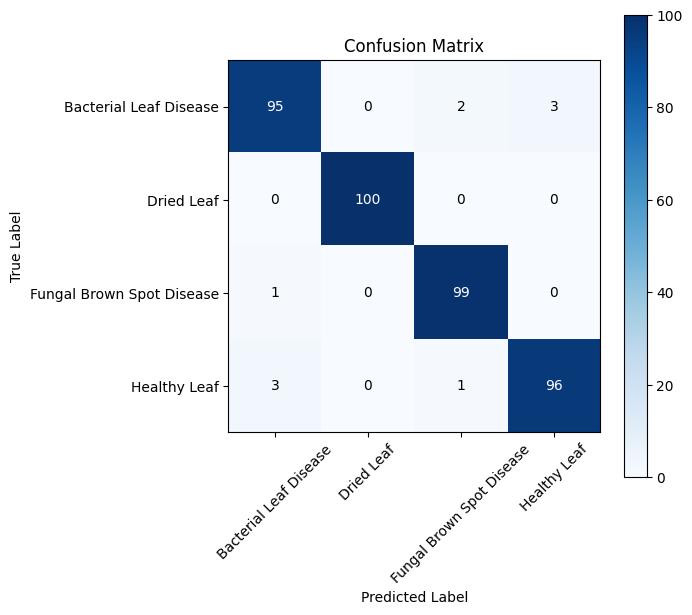

In [17]:
# Evaluate the model
evaluate_model(model, test_loader)

In [18]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'plant_disease_model.pth')
print("Model saved successfully!")

Model saved successfully!


Classification Report:
                           precision    recall  f1-score   support

   Bacterial Leaf Disease       0.99      0.98      0.99       143
               Dried Leaf       0.96      1.00      0.98        51
Fungal Brown Spot Disease       1.00      1.00      1.00        54
             Healthy Leaf       0.98      0.98      0.98        49

                 accuracy                           0.99       297
                macro avg       0.98      0.99      0.99       297
             weighted avg       0.99      0.99      0.99       297



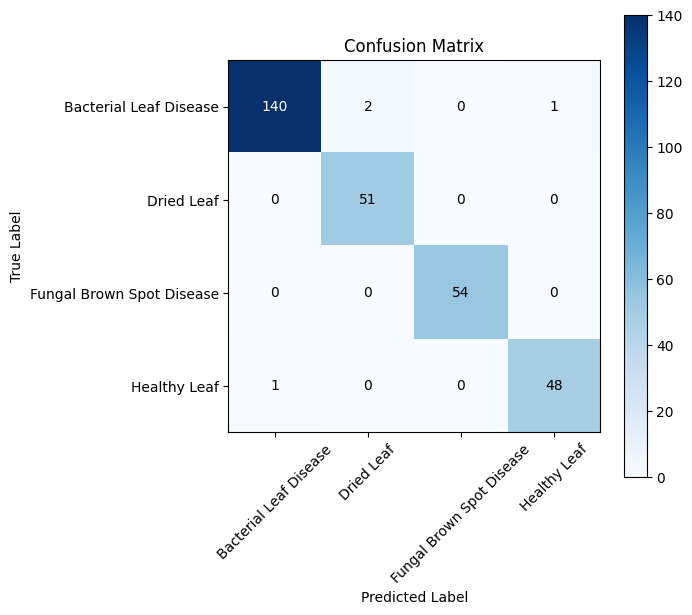

In [19]:
# Define the path to the new set of images
new_test_dir = './Betel Leaf Image Dataset from Bangladesh/Augmented Images/Test'  # Path to your new test data folder

# Create a new dataset and dataloader for the new set of images
new_test_dataset = PlantDiseaseDataset(new_test_dir)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the new set of images
evaluate_model(model, new_test_loader)

In [19]:
import ipywidgets as widgets
from IPython.display import display, Image as IPImage
from PIL import Image
import io
import numpy as np

# Load the saved model state dictionary
model.load_state_dict(torch.load('plant_disease_model.pth'))
model = model.to(device)
model.eval()

# Create a file upload widget
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)

# Create an output widget to display the prediction
output = widgets.Output()
display(output)

def on_upload_change(change):
    for file_info in upload.value:
        print("File uploaded:", file_info['name'])  # Debug print
        # Load the image
        img = Image.open(io.BytesIO(file_info['content']))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        
        # Convert the image to tensor
        img_tensor = torch.tensor(np.array(img)).float()
        img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)  # Change shape from HWC to CHW format and add batch dimension
        img_tensor = img_tensor.to(device)
        
        # Perform prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_class_name = list(class_names.keys())[list(class_names.values()).index(predicted.item())]
        
        # Display the uploaded image and prediction
        with output:
            output.clear_output()
            display(IPImage(data=file_info['content'], format='png'))
            print(f"Predicted class: {predicted_class_name}")

upload.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

Output()